In [1]:
"""
Dataset: Chess Game Dataset from Lichess
    
    20,000+ Lichess games
    This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org. 
    
    This set contains the:

    Game ID;
    Rated (T/F);
    Start Time;
    End Time;
    Number of Turns;
    Game Status;
    Winner;
    Time Increment;
    White Player ID;
    White Player Rating;
    Black Player ID;
    Black Player Rating;
    All Moves in Standard Chess Notation;
    Opening Eco (Uses ECO Codes);
    Opening Name;
    Opening Ply (Number of moves in the opening phase)
"""

'\nChess Game Data Science Project 1\n\nDataset: Chess Game Dataset from Lichess\n    \n    20,000+ Lichess games\n    This is a set of just over 20,000 games collected \n    from a selection of users on the site Lichess.org, and how to collect more. \n    I will also upload more games in the future as I collect them. This set contains the:\n\n    Game ID;\n    Rated (T/F);\n    Start Time;\n    End Time;\n    Number of Turns;\n    Game Status;\n    Winner;\n    Time Increment;\n    White Player ID;\n    White Player Rating;\n    Black Player ID;\n    Black Player Rating;\n    All Moves in Standard Chess Notation;\n    Opening Eco (Uses ECO Codes);\n    Opening Name;\n    Opening Ply (Number of moves in the opening phase)\n'

In [3]:
"""
MAIN QUESTION: 
                DO CERTAIN OPENINGS CONSISTENTLY LEAD TO BETTER OUTCOMES?
"""

'\nMAIN QUESTION: \n            DO CERTAIN CHESS OPENINGS CONSISTENTLY LEAD TO BETTER OUTCOMES?\n'

In [3]:
#Load dataset 

import pandas as pd 

games = pd.read_csv("/Users/exequielfleitas/data/chess_games.csv")

games.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4


In [5]:
# MODEL 1: Logidtic Regression
# Encode "winner" variables as binary variable (White wins = 1, White loses or draw = 0)
# Calculate and create varible rating_diff = white_rating - black_rating
# Encode "rated" as a binary variable (True = 1 and False = 0)
# Encode the opening ECO code A,B,C,D,E (Something more broad)
# NaNs; Numeric columns = median, Categorical columns = "Unknown"
# Time control we will use "increment_code" (ex: 3+0 = blitz, 5+3 = rapid)

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


# Create "white_win" binary variable column
games["white_win"] = (games["winner"] == "white").astype(int)

# Create "rating_diff" column 
games["rating_diff"] = (
    games["white_rating"] - games["black_rating"] )

# Create "opening_family" column 
games["opening_family"] = games["opening_eco"].str[0]

games.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply',
       'white_win', 'rating_diff', 'opening_family'],
      dtype='object')

In [8]:
#Select the features we need
features = [
    "rating_diff",
    "opening_ply",
    "rated",
    "opening_family",
    "increment_code"
]

X = games[features]
y = games["white_win"]

In [9]:
# Train / test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, 
                                                    stratify = y )

In [10]:
# Processes 
numeric_features = ["rating_diff", "opening_ply"]
binary_features = ["rated"]
categorical_features = ["opening_family", "increment_code"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", "passthrough", binary_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
# Logistic regression model 
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter = 1000))
])

In [12]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rating_diff',
                                                   'opening_ply']),
                                                 ('bin', 'passthrough',
                                                  ['rated']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['opening_family',
                                                   'increment_code'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [18]:
# Evaluate 
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6306081754735793
ROC AUC: 0.6884829771371769

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      2012
           1       0.63      0.62      0.62      2000

    accuracy                           0.63      4012
   macro avg       0.63      0.63      0.63      4012
weighted avg       0.63      0.63      0.63      4012



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
'''
Accuracy: The model correctly predicts the outcome 63% of the time (Random guessing is ~50%)
    The model performs substantially better than chance, indicating that pre-game features such 
    as player rating, opening choice, and time control contain predictive information about game outcomes.


ROC AUC: Measures how well the model separates wins from non-wins
    An ROC AUC of 0.69 indicates the model has a good ability to distinguish 
    between games White will win and those it will not.


Class 1 (White win): 
    Precision = 0.63; When the model predicts White wins, it is correct 63% of the time.
    Recall = 0.62; The model correctly identifies 62% of actual White wins.
    F1-score = 0.62; Balanced measure of precision and recall.

Class 0 (Black wins or Draw):
    Metrics are almost identical, showing that the model treates both classes fairly

Conclusion:
The logistic regression model achieved an accuracy of 63% and an ROC AUC of 0.69, indicating 
moderate predictive performance. Given that the model relies solely on pre-game features, these 
results suggest that player ratings are the dominant factor in determining outcomes, while opening 
choice contributes additional but relatively small predictive signal. This supports the hypothesis 
that certain openings are associated with better outcomes, although their effect is secondary to 
player skill.

SyntaxError: incomplete input (1438365086.py, line 1)

In [23]:
# Rating-Only Model vs. Rating & Openings
# Isolates the effect of openings

features_rating_only = [
    "rating_diff",
    "rated",
    "increment_code"
]

X_r = games[features_rating_only]
y = games["white_win"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_r, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
numeric_features_r = ["rating_diff"]
binary_features_r = ["rated"]
categorical_features_r = ["increment_code"]

preprocessor_r = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features_r),
        ("bin", "passthrough", binary_features_r),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
        ]), categorical_features_r)
    ]
)

model_ratings_only = Pipeline([
    ("preprocessor", preprocessor_r),
    ("classifier", LogisticRegression(max_iter=1000))
])

model_ratings_only.fit(Xr_train, yr_train)

yr_prob = model_ratings_only.predict_proba(Xr_test)[:, 1]

print("Ratings-only ROC AUC:", roc_auc_score(yr_test, yr_prob))
print("Ratings + Openings ROC AUC:", roc_auc_score(y_test, y_prob))

Ratings-only ROC AUC: 0.6911048707753479
Ratings + Openings ROC AUC: 0.6884829771371769


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Extract coefficients 

# Get feature names
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

coefficients = model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient
214,cat__increment_code_25+4,1.233331
27,cat__increment_code_10+12,1.175112
145,cat__increment_code_17+3,1.135904
72,cat__increment_code_12+8,1.123538
89,cat__increment_code_13+40,1.103692
165,cat__increment_code_19+0,1.069577
206,cat__increment_code_25+10,1.061833
328,cat__increment_code_60+30,0.973763
299,cat__increment_code_5+25,0.944947
0,num__rating_diff,0.930318


In [29]:
# Visualize Opening Family Effects

# Create a reference dataframe
base_row = X_train.median(numeric_only=True)

opening_effects = []

for opening in games["opening_family"].unique():
    temp = base_row.copy()
    temp["opening_family"] = opening
    temp["rated"] = 1
    temp["increment_code"] = games["increment_code"].mode()[0]

    prob = model.predict_proba(pd.DataFrame([temp]))[0, 1]
    opening_effects.append((opening, prob))

opening_df = pd.DataFrame(opening_effects, columns=["Opening Family", "Predicted White Win Probability"])


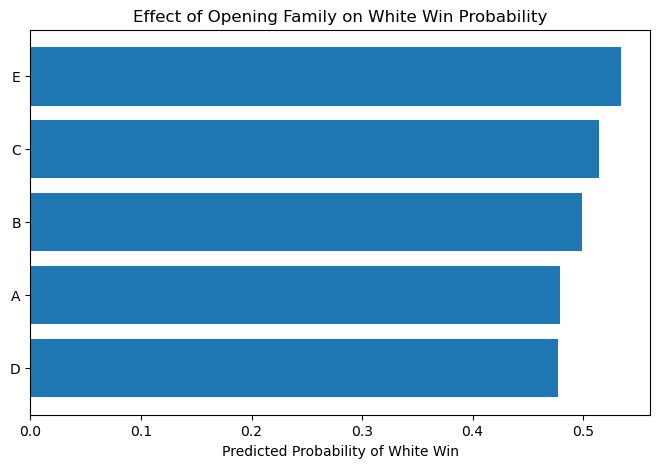

In [31]:
# Plot
import matplotlib.pyplot as plt

opening_df.sort_values("Predicted White Win Probability", inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(opening_df["Opening Family"], opening_df["Predicted White Win Probability"])
plt.xlabel("Predicted Probability of White Win")
plt.title("Effect of Opening Family on White Win Probability")
plt.show()


In [32]:
"""
Model Comparison:
    Ratings-only ROC AUC: 0.6911
    Ratings + Openings ROC AUC: 0.6885
        Adding opening information did not improve the model’s ability to distinguish White wins 
        from non-wins.

        Coefficients:
            num__rating_diff 0.930318: Positive and large; As White’s rating increases relative to Black, 
                                        White’s win probability increases strongly
            Longer time controls with increments are strongly associated with higher White win probability.


SyntaxError: incomplete input (1192721097.py, line 1)

In [35]:
"""

FINAL CONCLUSION: DO CERTAIN OPENINGS CONSISTENTLY LEAD TO BETTER OUTCOMES?

    After controlling for player rating and time control, opening choice does not significantly 
    improve the prediction of game outcomes. While certain openings may appear successful in 
    raw win-rate analysis, their apparent effectiveness is largely explained by stronger players 
    selecting those openings rather than by the openings themselves.

    A logistic regression model using only rating difference and time control achieved 
    an ROC AUC of 0.69. Adding opening-related features such as opening family and 
    opening ply did not improve model performance, suggesting that opening choice provides 
    limited independent predictive value once player strength is accounted for. 
    These results indicate that player skill and time control are the primary determinants of 
    game outcomes, while opening choice plays a secondary role.

"""

SyntaxError: incomplete input (501084540.py, line 1)